In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import pickle

In [45]:
with open("/workspace/MARS/pose_labels/subject14_all_labels.cpl", "rb") as f:
    cpl = pickle.load(f)

cpl.keys()

dict_keys(['naive_gt_kps', 'refined_gt_kps', 'rgb_est_kps', 'radar_est_kps', 'imu_est_kps', 'rgb_avail_frames', 'radar_avail_frames', 'imu_avail_frames', 'gt_avail_frames', '2d_l_avail_frames', '2d_r_avail_frames', 'pose_2d_l', 'pose_2d_r', 'video_label', 'camera_matrix'])

In [50]:
def plot_3d_skeleton(keypoints, connections, swap_axes=None, skeleton_on=True):  
    # Swap axes if specified  
    if swap_axes:  
        keypoints = keypoints[:, swap_axes]  
  
    # Create a 3D plot  
    fig = plt.figure(figsize=(10,10))  
    ax = fig.add_subplot(111, projection='3d')  
  
    # Plot keypoints  
    ax.scatter(keypoints[:, 0], keypoints[:, 1], keypoints[:, 2], c='r', marker='o')  

    # Annotate keypoints with their indices  
    for i, (x, y, z) in enumerate(keypoints):  
        ax.text(x, y, z, f'{i}', color='black')
  
    # Plot connections  
    if skeleton_on:
        for connection in connections:  
            point1 = keypoints[connection[0]]  
            point2 = keypoints[connection[1]]  
            ax.plot(
                [point1[0], point2[0]], 
                [point1[1], point2[1]], 
                [point1[2], point2[2]], 
                'b-'
            )  
  
    # Set labels  
    ax.set_xlabel('X')  
    ax.set_ylabel('Y')  
    ax.set_zlabel('Z')  
  
    # plt.gca().invert_yaxis()
    # plt.gca().invert_zaxis()
    # Show plot  
    plt.show()  

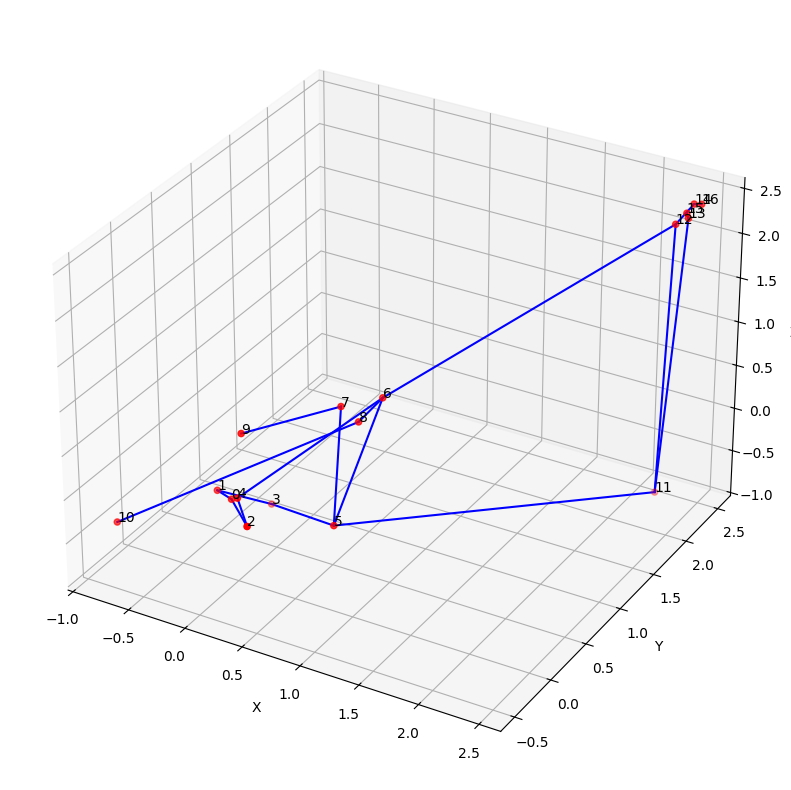

In [53]:
# Sample data: replace this with your actual data  
import numpy as np
idx = 200
keypoints = np.reshape(cpl['refined_gt_kps'][idx], (17, 3))  # Replace with your actual keypoints array  
  
# Define connections between keypoints to form the skeleton  
connections = [
    (9,7), (7,5), (5,6), (6,8), (8,10),
    (5,3), (3,1), (1,0), (0,2), (2,4), (4,6),
    (5,11), (11,13), (13,15),
    (11,12),
    (6,12), (12,14), (14,16),
]
plot_3d_skeleton(keypoints, connections, swap_axes=(2,1,0), skeleton_on=True)

In [41]:
np.unique(cpl['refined_gt_kps'][idx])

array([-0.8203825 , -0.7872495 , -0.39738077, -0.38487935, -0.38068163,
       -0.36524174, -0.3213192 , -0.2571874 , -0.24166274, -0.23669264,
       -0.22929998, -0.18854608, -0.15469575, -0.12021988, -0.07227623,
       -0.00829831,  0.00380158,  0.0055017 ,  0.02678363,  0.03182152,
        0.04240684,  0.10987168,  0.24944805,  0.31068882,  0.5214555 ,
        0.5216714 ,  0.52386844,  0.5294217 ,  0.55794215,  0.7346638 ,
        0.7356477 ,  0.7482313 ,  0.7615558 ,  0.7714196 ,  2.2722101 ,
        2.2970874 ,  2.3005366 ,  2.3067555 ,  2.3822458 ,  2.3865776 ,
        2.393307  ,  2.403325  ,  2.4042156 ,  2.4059207 ,  2.4079454 ,
        2.4392068 ,  2.453677  ,  2.4614425 ,  2.484     ,  2.4984465 ,
        2.5561562 ], dtype=float32)

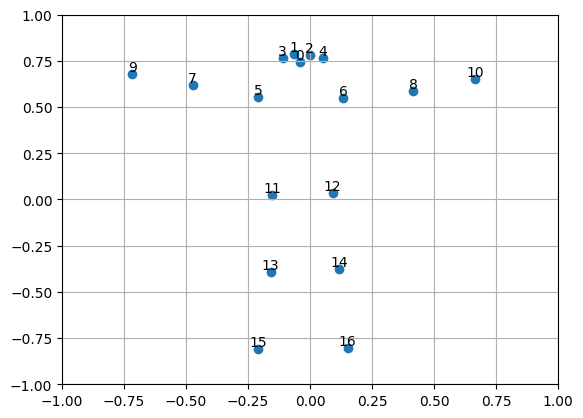

In [48]:
import numpy as np

pts = cpl['refined_gt_kps'][idx]
x_axis = 0
y_axis = 1

fig, ax = plt.subplots()
# plt.gca().invert_yaxis()
ax.scatter(pts[x_axis], pts[y_axis])
for i, (x_coord, y_coord) in enumerate(zip(pts[x_axis], pts[y_axis]), start=0):
    plt.annotate(
        str(i), 
        (x_coord, y_coord), 
        textcoords="offset points", 
        xytext=(0, 2), 
        ha="center"
    )
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.grid()
plt.show()


In [5]:
connections = [
    (9,7), (7,5), (5,6), (6,8), (8,10),
    (5,3), (3,1), (1,0), (0,2), (2,4), (4,6),
    (5,11), (11,13), (13,15),
    (11,12),
    (6,12), (12,14), (14,16),
]
connections = [
    (11,9), (9,7), (7,6), (6,8), (8,10),
    (7,5), (5,3), (3,2), (2,1), (1,2), (2,4), (4,6),
    (7,13), (13,15), (15,17),
    (6,12), (12,14), (14,16),
    (13,12)
]

NameError: name 'connections' is not defined

In [19]:
vid_filename = "blurred_videos/subject14_0505/subject14_color1.mp4"
frame_number = 200
import cv2
cap = cv2.VideoCapture(vid_filename)
amount_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print(amount_of_frames)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
res, frame = cap.read()
print(res)
frame.shape

6981.0
True


(1080, 1920, 3)

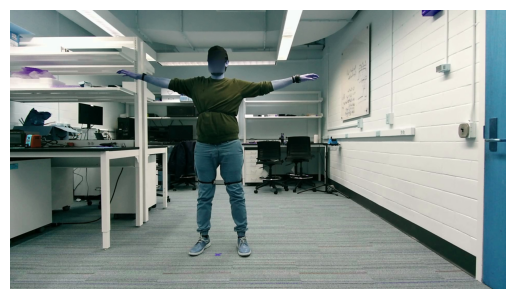

In [18]:
plt.imshow(frame)
plt.axis('off')
plt.show()


## ======================

In [16]:
import typing as tp
import numpy as np
import matplotlib.pyplot as plt


def get_chain_dots(
        dots: np.ndarray,   # shape == (n_dots, 3)
        chain_dots_indexes: tp.List[int], # length == n_dots_in_chain
                                          # in continuous order, i.e. 
                                          # left_hand_ix >>> chest_ix >>> right_hand_ix
        ) -> np.ndarray:    # chain of dots
    """Get continuous chain of dots
    
    chain_dots_indexes - 
        indexes of points forming a continuous chain;
        example of chain: [hand_l, elbow_l, shoulder_l, chest, shoulder_r, elbow_r, hand_r]
    """
    return dots[chain_dots_indexes]


def get_chains(
        dots: np.ndarray,   # shape == (n_dots, 3)
        spine_chain_ixs: tp.List[int], # pelvis >>> chest >>> head
        hands_chain_ixs: tp.List[int], # left_hand >>> chest >>> right_hand
        legs_chain_ixs: tp.List[int]   # left_leg >>> pelvis >>> right_leg
        ):
    return (get_chain_dots(dots, spine_chain_ixs),
            get_chain_dots(dots, hands_chain_ixs),
            get_chain_dots(dots, legs_chain_ixs))


def subplot_nodes(dots: np.ndarray, # shape == (n_dots, 3)
                  ax):
    return ax.scatter3D(*dots.T, c=dots[:, -1])


def subplot_bones(chains: tp.Tuple[np.ndarray, ...], ax):
    return [ax.plot(*chain.T) for chain in chains]


def plot_skeletons(
        skeletons: tp.Sequence[np.ndarray], 
        chains_ixs: tp.Tuple[tp.List[int], tp.List[int], tp.List[int]]):
    fig = plt.figure(figsize=(15, 30))
    for i, dots in enumerate(skeletons, start=1):
        chains = get_chains(dots, *chains_ixs)
        ax = fig.add_subplot(2, 5, i, projection='3d')
        subplot_nodes(dots, ax)
        subplot_bones(chains, ax)
    plt.show()


In [19]:
np.reshape(cpl['refined_gt_kps'][0:10], (10, 17, 3)).shape

(10, 17, 3)

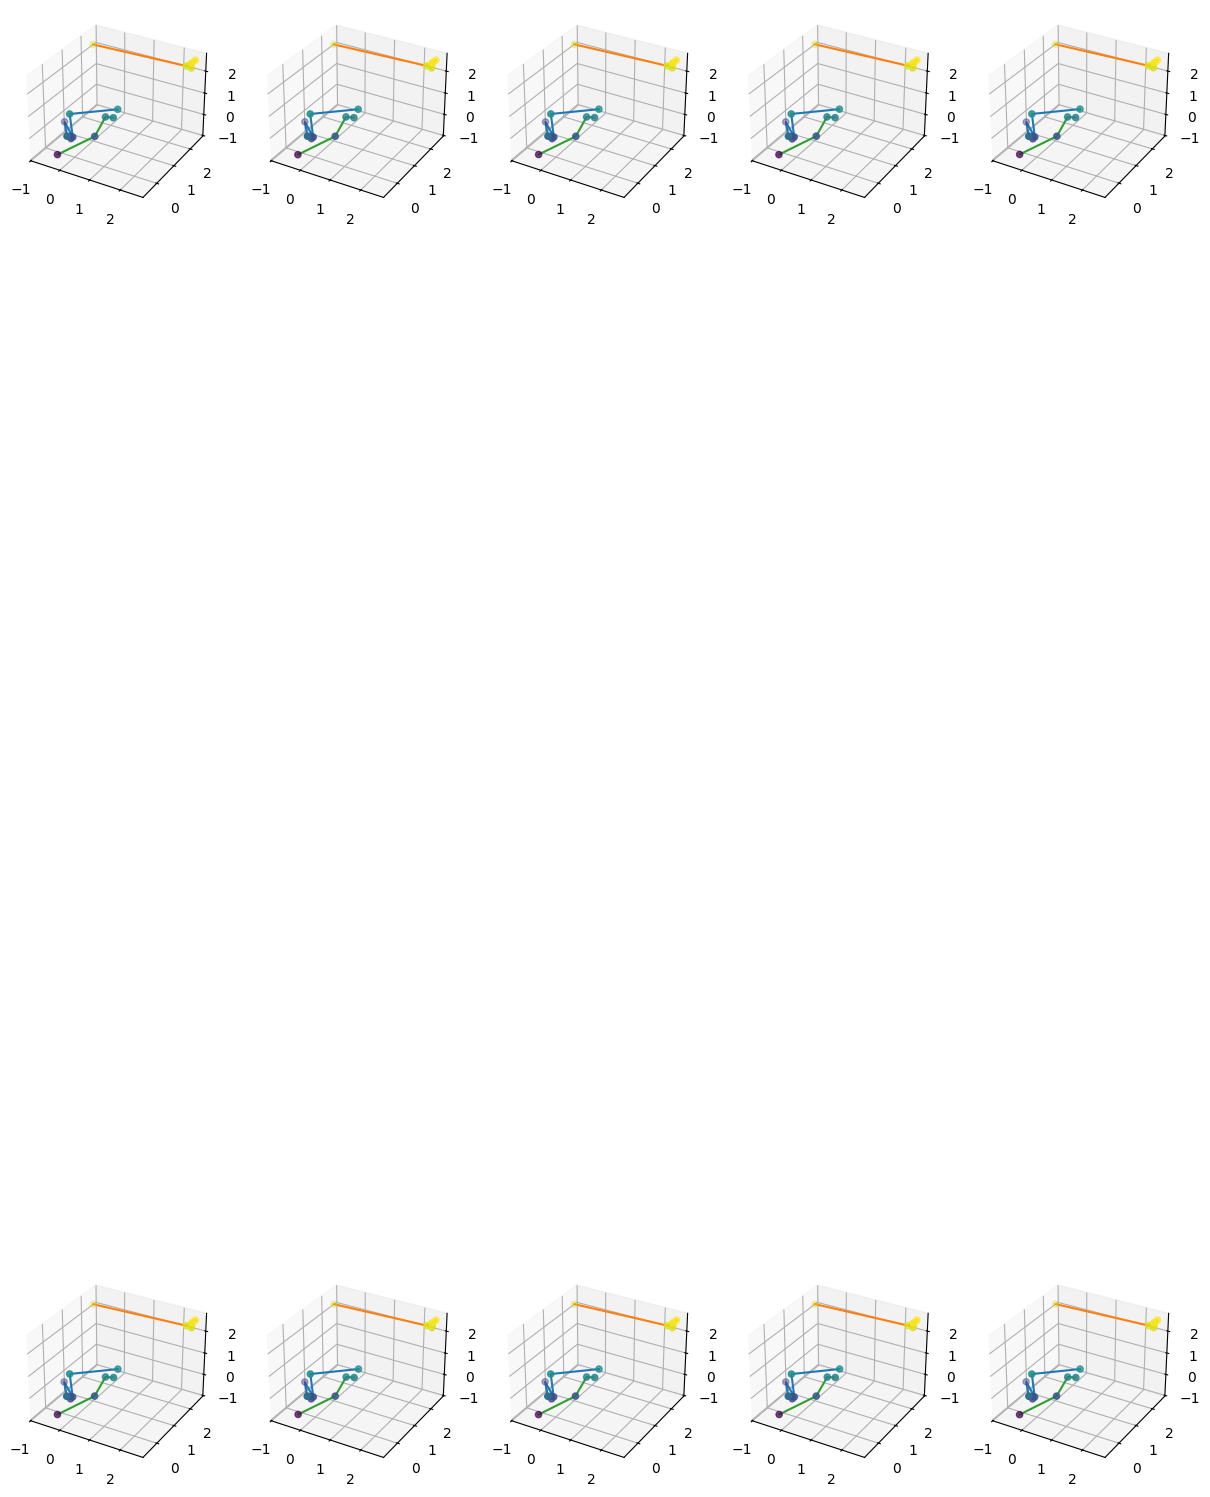

In [27]:
skeletons = np.reshape(cpl['refined_gt_kps'][100:110], (10, 17, 3))
# """Plot random poses of simplest skeleton"""
chains_ixs = ([0, 1, 2, 3, 4, 5, 6],  # hand_l, elbow_l, chest, elbow_r, hand_r
                [11, 12, 13, 14, 15, 16],        # pelvis, chest, head
                [7, 8, 9, 10]) # foot_l, knee_l, pelvis, knee_r, foot_r

# skeletons = np.random.standard_normal(size=(10, 11, 3))
# chains_ixs = ([0, 1, 2, 3, 4],  # hand_l, elbow_l, chest, elbow_r, hand_r
#                 [5, 2, 6],        # pelvis, chest, head
#                 [7, 8, 5, 9, 10]) # foot_l, knee_l, pelvis, knee_r, foot_r
plot_skeletons(skeletons, chains_ixs)